In [1]:
import pandas as pd
from datetime import timedelta
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, precision_score, recall_score

# Multilayer perceptrons

## Objectives

* Review: describe logistic regression
* Describe a "neuron", "unit", "hidden layer"
* Describe an activation function
* Use Tensorflow to find gradients of complex models
* Use Tensorflow to perform optimization
* Use Keras to define and train models
* Interpet the meaning of a neuron activation


## Hidden Layers

We know two things:

* Neural networks are basically logistic regression.
* Gradient descent can get us real far.

Here's an idea just daring enough it might work:

* What if we do logistic regression in order to classify our samples as some _latent things_.
* And then we do logistic regression using the _latent things_ as features.

For example:

* Take a dataset for customers of a rideshare company:
* Predict if each sample is
 * A business traveler
 * A casual traveler
 * Consistently careless and rude
 * A late night party animal
 * Any number of other personas
* Once we've established which categories they belong in, use that to predict if they'll churn.

To discover this "hidden layer" of personas, we'll just initalize feature->persona and persona->churn connections at random, and use the gradient of the loss to slowly move the weights to improve the final loss.

Hopefull, this will result in the discovery of the intermediate hidden layer.


## get that data

Let's grab the Fantasy Uber dataset.

In [2]:
df = pd.read_csv("churn.csv", parse_dates=["last_trip_date","signup_date"])

In [3]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [4]:
today = df.last_trip_date.max()

Engineer some features.

In [5]:
city_dummies = pd.get_dummies(df.pop("city"))
phone_dummies = pd.get_dummies(df.pop("phone"))
df["signup_dow"] = df.signup_date.dt.weekday
df["age"] = (today - df.signup_date).dt.days
df["pass_rating_blank"] = df.avg_rating_by_driver.isna()
df["driver_rating_blank"] = df.avg_rating_of_driver.isna()
df["avg_rating_by_driver"] = df.avg_rating_by_driver.fillna(df.avg_rating_by_driver.mean())
df["avg_rating_of_driver"] = df.avg_rating_of_driver.fillna(df.avg_rating_of_driver.mean())

Engineer the target, a binary variable for churn.

In [6]:
y = (df.last_trip_date <= today-timedelta(days=30)).astype(float).values
y = np.expand_dims(y, axis=1)

Drop non-numeric columns and get the raw matrix.

In [7]:
df = df.drop(["last_trip_date","signup_date"], axis=1)
X = df.values.astype(float)

The model proceeds in two steps. In the first step, we make a random guess about the linear mapping of the 12 input features to 6 output features, and then apply a matrix to get the output features:

In [8]:
np.random.seed(42)

#parameters for hidden layer
W_hidden = tf.Variable(np.random.normal(size=(12,6)))
b_hidden = tf.Variable(np.zeros(shape=(6)))

In [9]:
X @ W_hidden + b_hidden

<tf.Tensor: id=19, shape=(50000, 6), dtype=float64, numpy=
array([[ 157.51801023,  123.42623012, -224.01717846,  -76.56557536,
          14.25859132,  192.57573125],
       [ 164.94845967,  115.62099873, -205.83461763,  -71.8160556 ,
          17.04969972,  199.22173678],
       [ 176.49691555,  133.44306734, -303.39512446, -128.33701125,
           7.92108939,  271.16321516],
       ...,
       [ 155.8146044 ,   93.8258662 , -281.61212978, -114.46447596,
          -6.22986826,  252.55168131],
       [ 168.40335502,  123.18683328, -290.92950499, -119.47080611,
           4.89119767,  264.58938538],
       [ 180.56497915,  138.0565267 , -142.20821978,  -48.06636208,
          43.57663036,  161.46131166]])>

Then we use a sigmoid function to squish the linear output features to a range between 0 and 1.

In [10]:
unseen_activation = tf.sigmoid( X @ W_hidden + b_hidden ).numpy().astype(np.float16)
unseen_activation

array([[1.      , 1.      , 0.      , 0.      , 1.      , 1.      ],
       [1.      , 1.      , 0.      , 0.      , 1.      , 1.      ],
       [1.      , 1.      , 0.      , 0.      , 0.9995  , 1.      ],
       ...,
       [1.      , 1.      , 0.      , 0.      , 0.001966, 1.      ],
       [1.      , 1.      , 0.      , 0.      , 0.9927  , 1.      ],
       [1.      , 1.      , 0.      , 0.      , 1.      , 1.      ]],
      dtype=float16)

Every row of the output corresponds to an input sample, and every column responds to an unseen "feature".

In [11]:
unseen_activation.shape

(50000, 6)

In [12]:
unseen_activation[0]

array([1., 1., 0., 0., 1., 1.], dtype=float16)

In the second stage, we take the unseen layer, and apply an arbirary set of weights and biases to calculate a sigmoid output.

In [13]:
#parameters for final logistic regression
W_final = tf.Variable(np.ones(shape=(6,1)))
b_final = tf.Variable(0.0,dtype=tf.double)

In [14]:
yhat = tf.sigmoid( unseen_activation @ W_final + b_final )
yhat

<tf.Tensor: id=47, shape=(50000, 1), dtype=float64, numpy=
array([[0.98201379],
       [0.98201379],
       [0.98200516],
       ...,
       [0.95266289],
       [0.98188397],
       [0.98201379]])>

This is our final prediction. It's wrong, but it's a start. It's essential that we can come up with a differentiable function that describes _how_ wrong it is. Here's binary cross-entropy.

In [15]:
tf.reduce_sum( tf.keras.backend.binary_crossentropy(y, yhat) )

<tf.Tensor: id=69, shape=(), dtype=float64, numpy=71160.3055911408>

## Automatic gradients with TensorFlow

Same code as above, but packaged up.

In [16]:
np.random.seed(42)

#parameters for hidden layer
n_hidden_units = 100
W_hidden = tf.Variable(np.random.normal(size=(12,n_hidden_units)))
b_hidden = tf.Variable(np.zeros(shape=(n_hidden_units)))

#parameters for final logistic regression
W_final = tf.Variable(np.ones(shape=(n_hidden_units,1)))
b_final = tf.Variable(0.0,dtype=tf.double)

In [17]:
def model(X, W_hidden, b_hidden, W_final, b_final):
    #find activation of hidden layer
    hidden_activation = tf.math.sigmoid( X @ W_hidden + b_hidden )

    #find prediction
    return tf.math.sigmoid( hidden_activation@W_final + b_final )

In [18]:
def getloss(y, yhat):
    return tf.reduce_sum( tf.keras.backend.binary_crossentropy(y, yhat) )

In [19]:
yhat = model(X, W_hidden, b_hidden, W_final, b_final)
getloss(y, yhat)

<tf.Tensor: id=130, shape=(), dtype=float64, numpy=282430.80649781297>

We can use a gradient tape to record the process of W_hidden being processed into a loss.

In [20]:
with tf.GradientTape() as t:
    t.watch(W_hidden)
    
    yhat = model(X, W_hidden, b_hidden, W_final, b_final)
    loss = getloss(y, yhat)

Now the gradient tape has recorded a single forward pass of the computation graph, which it can use to do a backwards pass and get the gradient of the hidden layer weights.

In [21]:
dloss_dWhidden = t.gradient(loss, W_hidden).numpy()

In [22]:
dloss_dWhidden[:,3]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [46]:
# start those weights back at the beginning

np.random.seed(42)

#parameters for hidden layer
W_hidden = tf.Variable(np.random.normal(size=(12,6)))
b_hidden = tf.Variable(np.zeros(shape=(6)))

#parameters for final logistic regression
W_final = tf.Variable(np.ones(shape=(6,1)))
b_final = tf.Variable(0.0,dtype=tf.double)

In [47]:
#we need a function with no arguments that makes the loss tensor
def foo():
    return getloss(y, model(X, W_hidden, b_hidden, W_final, b_final))

In [48]:
foo()

<tf.Tensor: id=545889, shape=(), dtype=float64, numpy=71160.2542384141>

In [49]:
trace = [] #for keeping track of the loss during training

In [50]:
optimizer = tf.optimizers.RMSprop()

for i in range(1000):
    optimizer.minimize(foo, [W_hidden, b_hidden, W_final, b_final])
    
    currloss = foo().numpy()
    print( i, currloss )
    trace.append(currloss)

0 70565.93989672372
1 70138.33169383326
2 69783.76761496278
3 69471.38078294278
4 69186.69069294826
5 68921.88368014414
6 68672.43079517984
7 68435.5085516601
8 68209.14782415263
9 67991.77645649252
10 67782.00621737403
11 67578.56417528511
12 67380.29348840984
13 67186.17545661342
14 66995.3495273571
15 66807.12325407393
16 66620.96964175209
17 66436.51002757337
18 66253.48214749582
19 66071.69770079482
20 65890.99993707832
21 65711.23458733686
22 65532.2418142612
23 65353.865274823314
24 65175.966483717944
25 64998.433268210036
26 64821.17696955777
27 64644.119801061606
28 64467.178871147094
29 64290.25497262036
30 64113.23164259373
31 63935.98496051961
32 63758.40029522864
33 63580.390875741374
34 63401.91428137041
35 63222.98466537433
36 63043.679059127695
37 62864.13563901784
38 62684.54187655559
39 62505.112061678345
40 62326.05713268224
41 62147.55444807088
42 61969.727178169735
43 61792.6389158537
44 61616.30233132233
45 61440.696272718924
46 61265.784220463756
47 61091.5276728

375 37359.80071114502
376 37324.46898195661
377 37289.226546642436
378 37254.06738301329
379 37218.98584848903
380 37183.97748406677
381 37149.039715260646
382 37114.1705093346
383 37079.36643746882
384 37044.61986287582
385 37009.91664488292
386 36975.231471041
387 36940.519781495685
388 36905.7026390486
389 36870.65145273451
390 36835.197454769914
391 36799.20145413659
392 36762.65090478737
393 36725.69262960217
394 36688.569078211964
395 36651.520406813455
396 36614.71634042861
397 36578.24145292953
398 36542.115154040366
399 36506.32123680637
400 36470.82891996465
401 36435.60576405283
402 36400.62264399957
403 36365.85611866829
404 36331.28755761769
405 36296.90296266336
406 36262.69127165606
407 36228.64426002858
408 36194.75512029939
409 36161.018762359294
410 36127.43064903855
411 36093.987376064775
412 36060.68562842389
413 36027.522929676896
414 35994.49663395413
415 35961.60478141437
416 35928.84508480108
417 35896.215855393966
418 35863.71496703522
419 35831.34083010576
420

743 31689.538801225408
744 31689.08249676242
745 31688.63398017773
746 31688.180361517196
747 31687.734028155137
748 31687.278865876695
749 31686.8310323926
750 31686.374296744412
751 31685.926035425495
752 31685.471592683065
753 31685.025935933765
754 31684.576054099005
755 31684.13450304729
756 31683.68917507453
757 31683.251765665344
758 31682.80979224302
759 31682.375422244033
760 31681.934916682312
761 31681.501762260683
762 31681.061343888436
763 31680.62838490682
764 31680.18850156998
765 31679.75638374913
766 31679.318503287956
767 31678.88842586897
768 31678.453442572394
769 31678.02604865581
770 31677.593885863917
771 31677.169057821404
772 31676.738963802156
773 31676.31599184147
774 31675.8870023627
775 31675.4650290749
776 31675.03659451574
777 31674.615224873793
778 31674.18752191309
779 31673.76696684581
780 31673.340482598593
781 31672.921108536342
782 31672.49604183047
783 31672.07791870369
784 31671.653956098875
785 31671.23670661856
786 31670.813118875274
787 31670.3

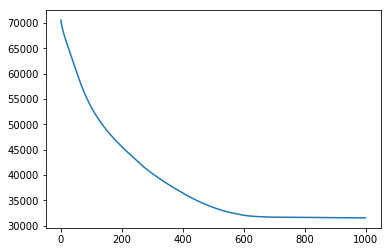

In [51]:
plt.plot(trace)

In [52]:
y.mean()

0.6338

In [53]:
yhat = model(X, W_hidden, b_hidden, W_final, b_final).numpy().flatten()

In [54]:
yhat

array([0.58981066, 0.58981066, 0.58981066, ..., 0.58981066, 0.58981066,
       0.82529943])

In [55]:
roc_auc_score(y.flatten(), yhat)

0.5753668517669898

In [56]:
activations = tf.math.sigmoid( X @ W_hidden + b_hidden ).numpy()

In [57]:
# only columns with index 3 and 4 have any variance

In [58]:
neuron_1 = (activations[:,3]>0.5)
neuron_2 = (activations[:,4]>0.5)

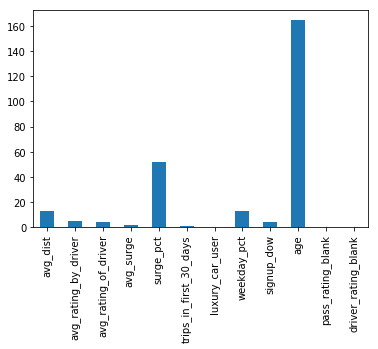

In [60]:
df[neuron_1].mean().plot.bar()

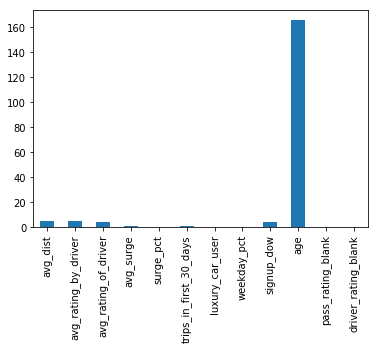

In [61]:
df[neuron_2].mean().plot.bar()

In [62]:
#df[neuron_1].mean() - df[neuron_2].mean()

Neuron 1 activates when a passenger takes surge ride and rides on the weekdays. Neuron 2 activates when the passenger rides less and only on the weekends. For about half of passengers, neither neuron activates.

## Model definition and training with Keras

Keras is an API for defining and training models at a high level.

In [63]:
# define and compile in one step
np.random.seed(42)

model = tf.keras.Sequential([
  tf.keras.layers.Dense(100, activation="sigmoid"),
  tf.keras.layers.Dense(1, activation="sigmoid")
])

# # it is possible to define a custom loss function
# def cross_entropy(y, yhat):
#     return tf.reduce_sum(-(y*tf.math.log(yhat)+(1-y)*tf.math.log(1-yhat)))

model.compile(optimizer='sgd',
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [64]:
y.mean()

0.6338

In [66]:
# train in a standard way
hist = model.fit(X,y, epochs=20, batch_size=256)

Epoch 1/20
50000/50000 [==============================] - 1s 13us/sample - loss: 0.5930 - accuracy: 0.6932
Epoch 2/20
50000/50000 [==============================] - 1s 13us/sample - loss: 0.5921 - accuracy: 0.6956
Epoch 3/20
50000/50000 [==============================] - 1s 12us/sample - loss: 0.5913 - accuracy: 0.6980
Epoch 4/20
50000/50000 [==============================] - 1s 11us/sample - loss: 0.5906 - accuracy: 0.6989
Epoch 5/20
50000/50000 [==============================] - 1s 14us/sample - loss: 0.5898 - accuracy: 0.7009
Epoch 6/20
50000/50000 [==============================] - 1s 12us/sample - loss: 0.5891 - accuracy: 0.7022
Epoch 7/20
50000/50000 [==============================] - 1s 13us/sample - loss: 0.5883 - accuracy: 0.7030
Epoch 8/20
50000/50000 [==============================] - 1s 13us/sample - loss: 0.5875 - accuracy: 0.7058
Epoch 9/20
50000/50000 [==============================] - 1s 13us/sample - loss: 0.5868 - accuracy: 0.7055
Epoch 10/20
50000/50000 [============

In [67]:
yhat = (model.predict(X)).ravel()

In [68]:
yhat

array([0.39228886, 0.5381247 , 0.6850452 , ..., 0.75326914, 0.73321927,
       0.80183136], dtype=float32)

In [69]:
roc_auc_score(y, yhat)

0.7366221282119467

In [70]:
W, b = model.layers[0].weights

In [71]:
hidden_activations = (tf.sigmoid( X @ W + b )>0.5).numpy()

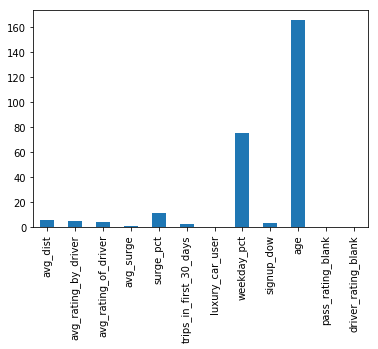

In [72]:
neuron_0_activators = df[ hidden_activations.T[0] ].mean()
neuron_0_activators.plot.bar()

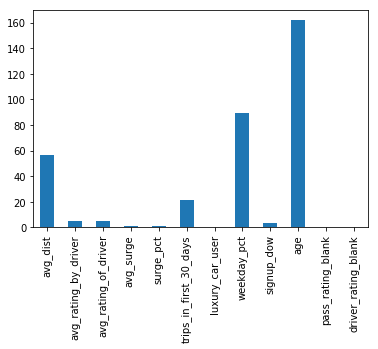

In [73]:
neuron_1_activators = df[ hidden_activations.T[1] ].mean()
neuron_1_activators.plot.bar()